<a href="https://colab.research.google.com/github/Liam-E2/NovSevenTweets/blob/master/DBSPEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
from matplotlib import style
style.use('default')

TODO:

Replace hacky mean change solution with linear regression?

Idea credit for GP Hyperparameter Optimization to Thomas Huijskens

https://thuijskens.github.io/2016/12/29/bayesian-optimisation/

https://www.youtube.com/watch?v=jtRPxRnOXnk


In [0]:
#url = "https://raw.githubusercontent.com/Liam-E2/NovSevenTweets/master/tweet_activity_metrics_livelessful_20191021_20191108_en.csv"
url = "https://raw.githubusercontent.com/Liam-E2/NovSevenTweets/master/tweet_activity_metrics_livelessful_20191021_20191113_en.csv"
df = pd.read_csv(url)
df.head()

,Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,app opens,app installs,follows,email tweet,dial phone,media views,media engagements,promoted impressions,promoted engagements,promoted engagement rate,promoted retweets,promoted replies,promoted likes,promoted user profile clicks,promoted url clicks,promoted hashtag clicks,promoted detail expands,promoted permalink clicks,promoted app opens,promoted app installs,promoted follows,promoted email tweet,promoted dial phone,promoted media views,promoted media engagements
0,1194320966748385282,https://twitter.com/livelessful/status/1194320...,@valeriazamare dm’s are always open 💛,2019-11-12 18:28 +0000,24.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,1194106936666525697,https://twitter.com/livelessful/status/1194106...,take a second and honestly turn notifications ...,2019-11-12 04:17 +0000,129.0,13.0,0.100775,0.0,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,1194104156652527616,https://twitter.com/livelessful/status/1194104...,just take a second to breathe. you’re doing al...,2019-11-12 04:06 +0000,226.0,19.0,0.084071,2.0,0.0,8.0,6.0,0.0,0.0,3.0,0.0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,1194015477980422144,https://twitter.com/livelessful/status/1194015...,"if you find joy in something, keep doing it. u...",2019-11-11 22:14 +0000,161.0,8.0,0.049689,0.0,0.0,6.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,1193930483081601024,https://twitter.com/livelessful/status/1193930...,be thankful for the people who love you. if yo...,2019-11-11 16:36 +0000,213.0,23.0,0.107981,2.0,0.0,9.0,3.0,0.0,0.0,9.0,0.0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [0]:
# Data Cleaning: Drop Irrelevant Columns
df.drop(columns=['Tweet id', 'Tweet permalink'], inplace=True)
promoted = [str(col) for col in df.keys() if 'promoted' in col]
df.drop(columns=promoted, inplace=True)

# Multiply Engagement Rate
df['engagement rate'] = df['engagement rate']*100

# Remove Snoop Outlier
print(len(df))
df = df[df.impressions != df.impressions.max()]
print(len(df))

# Time manipulation
df.time = pd.to_datetime(df.time)
df.time = df.time.dt.tz_convert('EST') #convert from UTC to EST (UTC -5)
df['hour'] = df.time.apply(lambda x: x.hour)
df['weekday'] = df.time.apply(lambda x: x.weekday)
df['dayofcampaign'] = df.time.apply(lambda x: x.date - datetime.date(2019, 10, 21))
df['dayofcampaign'] = df.dayofcampaign.apply(lambda x: x.days)
df.head()

53
52


,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,app opens,app installs,follows,email tweet,dial phone,media views,media engagements,hour,weekday,dayofcampaign
0,@valeriazamare dm’s are always open 💛,2019-11-12 13:28:00-05:00,24.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,13,1,22
1,take a second and honestly turn notifications ...,2019-11-11 23:17:00-05:00,129.0,13.0,10.077519,0.0,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,23,0,21
2,just take a second to breathe. you’re doing al...,2019-11-11 23:06:00-05:00,226.0,19.0,8.407080,2.0,0.0,8.0,6.0,0.0,0.0,3.0,0.0,0,0,0,0,0,0,0,23,0,21
3,"if you find joy in something, keep doing it. u...",2019-11-11 17:14:00-05:00,161.0,8.0,4.968944,0.0,0.0,6.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,17,0,21
4,be thankful for the people who love you. if yo...,2019-11-11 11:36:00-05:00,213.0,23.0,10.798122,2.0,0.0,9.0,3.0,0.0,0.0,9.0,0.0,0,0,0,0,0,0,0,11,0,21


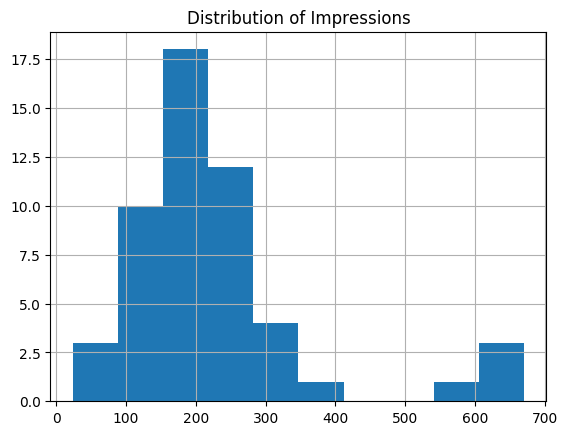

In [0]:
# Visualize the distribution of Impressions
plt.title("Distribution of Impressions")
df.impressions.hist()
# It almost looks like a log-normal distribution could do the trick

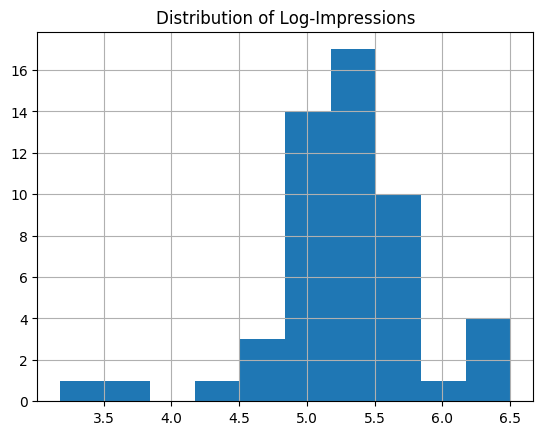

In [0]:
log = df.impressions
log = log.map(np.log)

plt.title("Distribution of Log-Impressions")
log.hist()

Log-normal distribution doesn't seem to cut it, unless it's some sort of weird heteroskedastic situation... time for more EDA

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


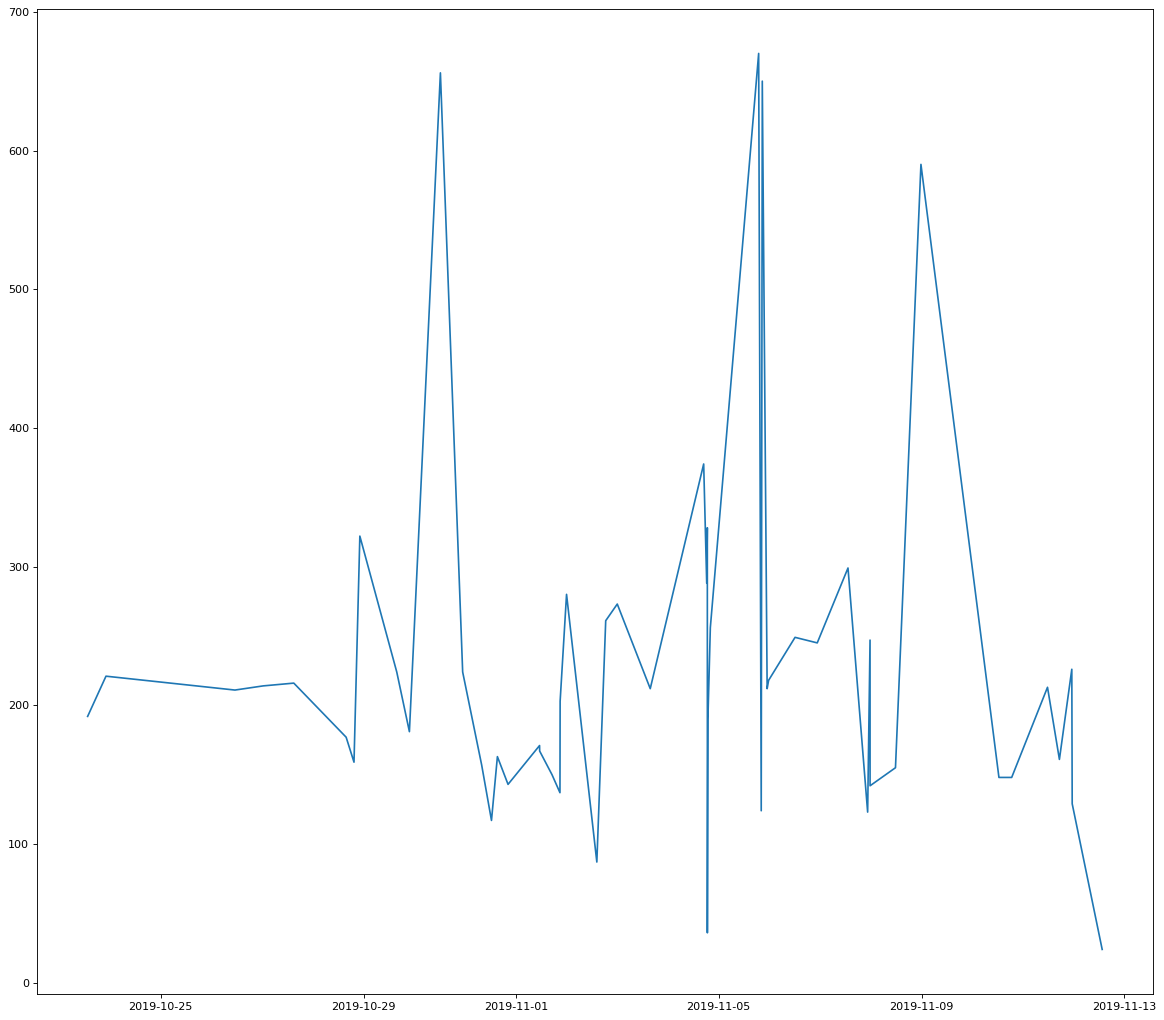

In [0]:
# Time series plot of Impressions
x = df.time
y = df.impressions

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, y)

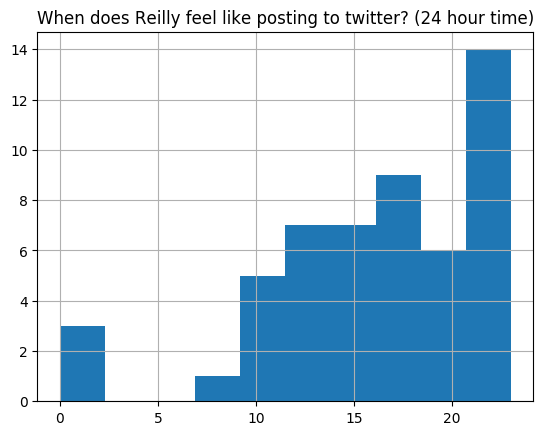

In [0]:
# Distribution of post times
plt.title("When does Reilly feel like posting to twitter? (24 hour time)")
df.hour.hist()

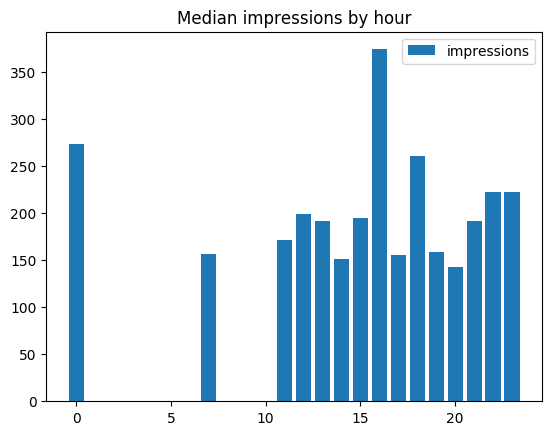

In [0]:
# Hourly Summary Data
pivot = df.pivot_table(values=['impressions', 'likes', 'engagement rate'], columns='hour', aggfunc=np.median).transpose().reset_index()


# Barchart of Data by Hour
field = 'impressions'

x = pivot.hour
y = pivot[field]

plt.title(f"Median {field} by hour")
plt.bar(x, y, label=field)
plt.legend()

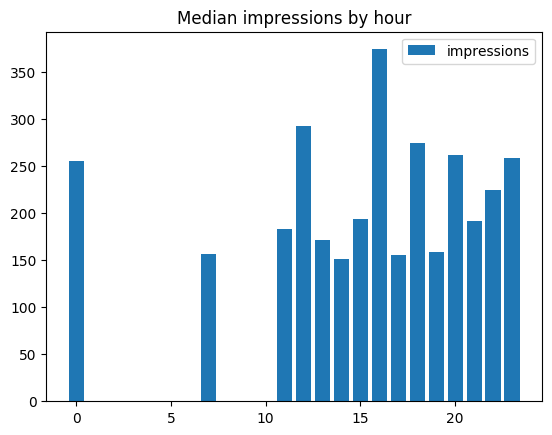

In [0]:
pivot2 = df.pivot_table(values=['impressions', 'likes', 'engagement rate'], columns=['hour'], aggfunc=np.mean).transpose().reset_index()

# Barchart of Data by Hour
field = 'impressions'

x = pivot2.hour
y = pivot2[field]

plt.title(f"Median {field} by hour")
plt.bar(x, y, label=field)
plt.legend()

Finding out an optimal strategy to understand post times could be helpful, if we want to make iterative, data-based decisions: a good strategy might by modelling with Gaussian Processes. They assume a costly, noisy output when optimizing black box function hyperparameters: maybe posting to twitter at some time and receiving n impressions can be thought of as a function instead of the more traditional ML setting?

In [0]:
import random
y = df.impressions
x = df.hour

TTSPLIT = 1
traincases = random.sample(range(len(y)), round(TTSPLIT*len(y)))

xtr = x.iloc[x.index.isin(traincases)]
ytr = y.iloc[y.index.isin(traincases)]
xtest = x.iloc[~x.index.isin(traincases)]
ytest = y.iloc[~y.index.isin(traincases)]

In [0]:
from sklearn.gaussian_process import *
kernel = kernels.Matern()*kernels.ConstantKernel() # Generalized Radial Basis Function * a constant term
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1, normalize_y=False)

model.fit(xtr.values.reshape(-1, 1), ytr.values.reshape(-1,1))
params = model.get_params()

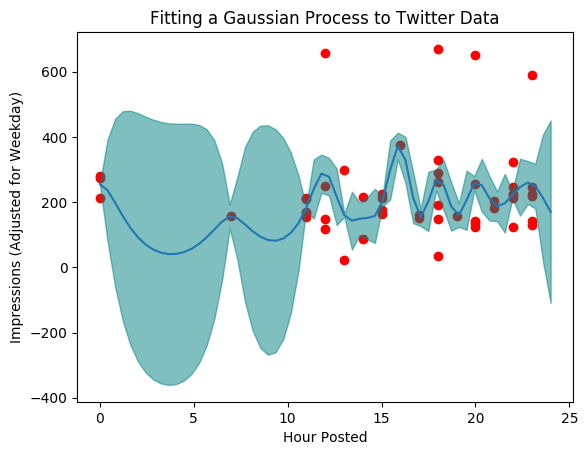

In [0]:
X = np.linspace(0, 24, 60)
X = np.atleast_2d(X).T

mu_s, std_s = model.predict(X, return_std=True)
upper = np.add(mu_s.flatten(), std_s*1.96)
lower = np.add(mu_s.flatten(), std_s*-1.96)

plt.title("Fitting a Gaussian Process to Twitter Data")
plt.ylabel('Impressions (Adjusted for Weekday)')
plt.xlabel('Hour Posted')

plt.scatter(xtr, ytr, label='Actual', color='red')
plt.fill_between(X.flatten(), y1=upper.flatten(), y2=lower.flatten(), color='teal', alpha=0.5)
plt.plot(X, mu_s, label='Predicted')


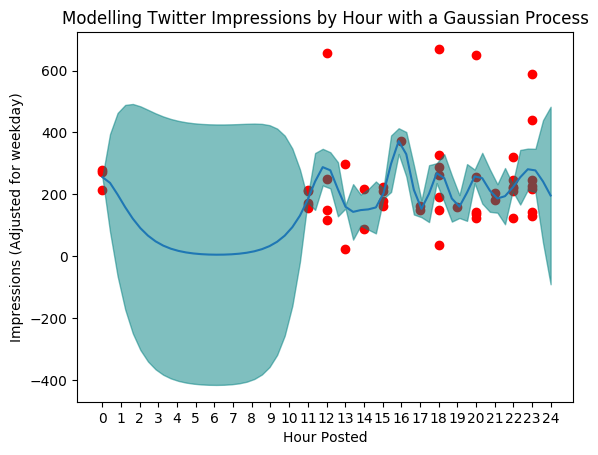

In [0]:
# Hacky solution to add newest tweet to test updating beliefs
# Bayesian updating for GPs is done by fitting GP to all past fit values
# So we just have to upload future data to github to use above for interpretation
# Dang, this method is cool for a stats nerd like myself

x = 23
y = 439
xtr[40] = x
ytr[40] = y

model.fit(xtr.values.reshape(-1, 1), ytr.values.reshape(-1,1))
params = model.get_params()

mu_s, std_s = model.predict(X, return_std=True)
upper = np.add(mu_s.flatten(), std_s*1.96)
lower = np.add(mu_s.flatten(), std_s*-1.96)
GPr = model.score(xtr.values.reshape(-1, 1), ytr.values.reshape(-1, 1))

plt.title("Modelling Twitter Impressions by Hour with a Gaussian Process")
plt.ylabel('Impressions (Adjusted for weekday)')
plt.xlabel('Hour Posted')
plt.xticks(np.arange(25))

plt.scatter(xtr, ytr, label='Actual', color='red')
plt.fill_between(X.flatten(), y1=upper.flatten(), y2=lower.flatten(), color='teal', alpha=0.5)
plt.plot(X, mu_s, label='Predicted')



# Clear heteroskedasticity in the data: look at the different lines above/below. Now fitting a model including time and weekday, which will be more difficult to visualize

In [0]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
xdum = pd.get_dummies(xtr)
lm.fit(xdum, ytr)
lmr = lm.score(xdum, ytr)

In [0]:
print(f'Gaussian Process Regression r^2: {GPr}')
print(f'Linear Regression r^2: {lmr}')

Gaussian Process Regression r^2: 0.13247030901241585
Linear Regression r^2: 0.13247030902080137


## Gaussian Process and Linear Regression with hourly dummy variables have equivalent r2, however GP also quantifies our uncertainty.

In a machine learning setting, we would implement some sort of algorithm to optimize the parameter "post time." The amount of work required to implement that for twitter posts is definitely not worth it. However, we can use this methodology to optimize post times the old-fashioned (human) way:

1) Looking at posterior distribution, identify peaks on the graph and areas with high uncertainty.

*Note: ignore the overnight times (roughly 1am-4am) under the assumption that most people will be asleep*

2) Schedule posts for the most promising identified time/times

3) The next day, export data for those posts and upload them to github, then running the script to update our beliefs and generate a new posterior distribution

4) Repeat until the end of the project, satisfied that we are rational actors in terms of tweet timing



In [0]:
# Weekday GP?
import random
y = df.impressions
x = pd.concat([df.hour, df.weekday], axis=1)

TTSPLIT = 1
traincases = random.sample(range(len(y)), round(TTSPLIT*len(y)))

xtr = x.iloc[x.index.isin(traincases)]
ytr = y.iloc[y.index.isin(traincases)]
xtest = x.iloc[~x.index.isin(traincases)]
ytest = y.iloc[~y.index.isin(traincases)]

In [0]:
kernel2 = kernels.Matern() # Generalized Radial Basis Function * a constant term
model2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=20, alpha=0.1, normalize_y=False)

model2.fit(xtr.values.reshape(len(xtr), -1), ytr.values.reshape(-1,1))
params2 = model.get_params()

0.688506942287662

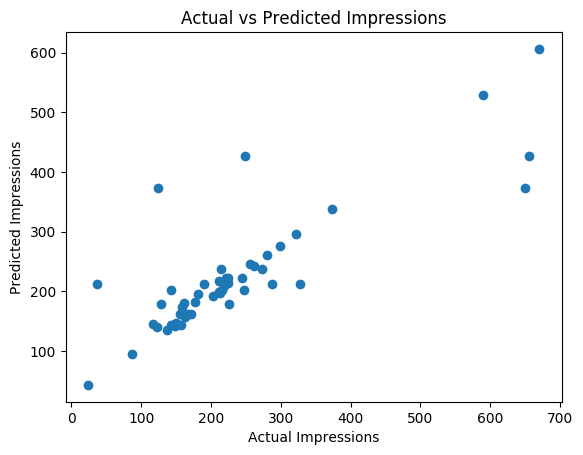

In [0]:
# Now that we have high-dimensional data, it's more difficult to visualize...

actual = ytr.values.reshape(-1, 1)
predicted = model2.predict(xtr.values.reshape(len(xtr), -1))

plt.title("Actual vs Predicted Impressions")
plt.scatter(actual, predicted)
plt.xlabel("Actual Impressions")
plt.ylabel("Predicted Impressions")

model2.score(xtr.values.reshape(len(xtr), -1), ytr.values.reshape(-1, 1))

In [0]:
# Gaussian Process describes data better than naive linear regression for interpreting, but predictive analysis is not a great idea here
# Not to be used for prediction, as it's almost certainly overfit; however, it is useful for describing our belief about the distribution of points
lm  = LinearRegression()
lm.fit(xtr, ytr)
lm.score(xtr, ytr)

0.01323617616141326

In [0]:
Gauss_rmse = np.sqrt(np.mean((actual - predicted)**2))

Gauss_rmse



76.85610851479557